# Time series

A time series are a succession of elements which are ordered by time.
In the datasets that have been studied so far, there was no notion of order between line.
On the contrary, it was even stressed that the id of the line was meaningless during the course of dimension reduction.
In time series, the order is the central component of the dataset.
In a time serie, the point is less about grouping similar points than to understand at which stage a similar behaviour seems to repeat itself.

Time series are extremely present in our daily lives.
The most famous ones are the prices of the stock market.
Those series contain a single scalar value, the price of a specific stock, as a function of time.
We are also regularly informed about various economic metrics, like unemployment, on a quarterly basis.

Most of the literature on time series focus on techniques to be able to predict the next values.
This applies in situations when we want to predict the future price of a stock, or estimates next month sales.
In this course, we will focus on understanding the properties of time series.
Like previous course, having a deep understanding of those properties greatly helps in choosing the proper predictive algorithm.

In this course, we will study a dataset of temperature measurement near the Orly airport near Paris.
The file ```src/data/meteo_france.py``` has all information to create this dataset.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src import *

In [ ]:
# Read only information about Orly city
orly = pd.read_parquet(ROOTDIR/'data'/'interim' / 'temperatures.parquet')
orly = orly.loc[orly['Nom']=='ORLY', ['date', 't']].set_index('date').sort_index()['t'].copy()
# change temperature to Celsius
orly = orly - 273.15
print(orly.shape)
orly.head()

(60993,)


date
2000-01-01 00:00:00    6.700006
2000-01-01 03:00:00    6.890009
2000-01-01 06:00:00    6.499994
2000-01-01 09:00:00    7.300012
2000-01-01 12:00:00    9.100000
Name: t, dtype: float64

## Basic description

Times series come in different shapes.
It is important to understand some basic properties in order to better anticipate what actions can be applied on the serie to extract insight or predict the future.
In this section, we will explore the most fundamental time series properties.

### Frequency

The frequency represents the time interval between two consecutive measurements. 
Depending on the field of study, data could be measured every hundreds of milliseconds (for electrocardiographs for example) or only annually like the statistics of international organisations. 
However, the natural frequency of the time serie may not be adapted to the objective of the analysis.
It is then possible to reduce the frequency with agregating functions and to create a more adapted time serie.

The previous print shows us that this time serie seems to have one temperature measurement every three hours.
This is the natural frequency of the dataset.
This level of precision may be too extreme for an analysis.
If we look at a graphical representation of those measurement, we observe that the high variations actually colour the graph and it is difficult to see daily behaviour.

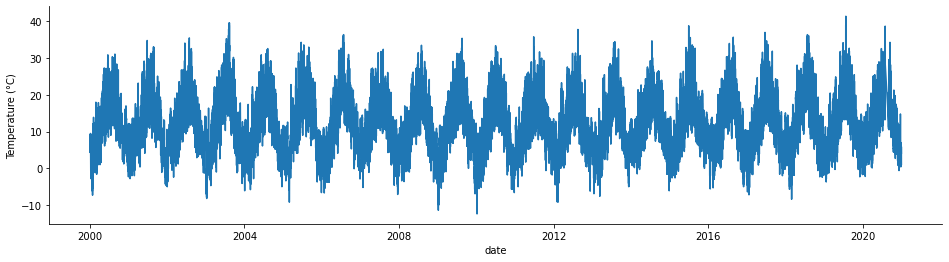

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(orly.index, orly);
ax.set_xlabel('date')
ax.set_ylabel('Temperature (°C)');

Instead we can agregate values that belong to the same time period in order to reduce the frequency of the serie.
In the case of temperature, we could take the average daily temperature.

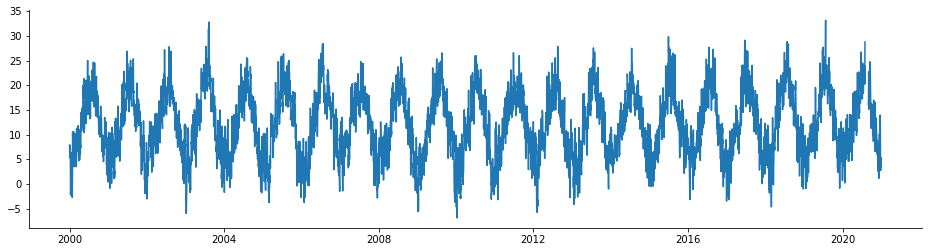

In [ ]:
orly_day = orly.resample('1D').mean()
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(orly_day.index, orly_day);

Even though the natural frequency of the dataset is 3 hours, it can happen that some timestamps are missing.
Let's look at all the measurements for the year 2019.

In [ ]:
orly19 = orly[orly.index.year==2019]
orly19

date
2019-01-01 00:00:00    7.899988
2019-01-01 03:00:00    6.999994
2019-01-01 06:00:00    7.100000
2019-01-01 09:00:00    7.800012
2019-01-01 12:00:00    8.100000
                         ...   
2019-12-31 09:00:00   -1.100012
2019-12-31 12:00:00    3.600000
2019-12-31 15:00:00    4.800012
2019-12-31 18:00:00    2.100000
2019-12-31 21:00:00   -0.699988
Name: t, Length: 2916, dtype: float64

Then we will generate all the timestamps that this dataset is supposed to contain.

In [ ]:
all_ts = pd.date_range('2019-01-01', '2020-01-01', freq='3H', closed='left')
all_ts

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 03:00:00',
               '2019-01-01 06:00:00', '2019-01-01 09:00:00',
               '2019-01-01 12:00:00', '2019-01-01 15:00:00',
               '2019-01-01 18:00:00', '2019-01-01 21:00:00',
               '2019-01-02 00:00:00', '2019-01-02 03:00:00',
               ...
               '2019-12-30 18:00:00', '2019-12-30 21:00:00',
               '2019-12-31 00:00:00', '2019-12-31 03:00:00',
               '2019-12-31 06:00:00', '2019-12-31 09:00:00',
               '2019-12-31 12:00:00', '2019-12-31 15:00:00',
               '2019-12-31 18:00:00', '2019-12-31 21:00:00'],
              dtype='datetime64[ns]', length=2920, freq='3H')

We can see that the generated values seem to match between the two lists but the second one has four additional elements.
This means that four measurements are missing in the dataset.
Some of the algorithms that we will present will be based on the difference between two dates so missing points will not be a problem.
However, others will be based on the succession of the points, which is more problematic is a missing point changes the theoretical order.
To counter this problem, we will inject those timestamps with missing values.
We can then decide to either use an algorithm that accept missing values or apply a filling strategy.

In [ ]:
orly19 = orly19.reindex(all_ts)
orly19

2019-01-01 00:00:00    7.899988
2019-01-01 03:00:00    6.999994
2019-01-01 06:00:00    7.100000
2019-01-01 09:00:00    7.800012
2019-01-01 12:00:00    8.100000
                         ...   
2019-12-31 09:00:00   -1.100012
2019-12-31 12:00:00    3.600000
2019-12-31 15:00:00    4.800012
2019-12-31 18:00:00    2.100000
2019-12-31 21:00:00   -0.699988
Freq: 3H, Name: t, Length: 2920, dtype: float64

We can then find back the four timestamps with missing values.

In [ ]:
print(orly19.isnull().sum())
orly19[orly19.isnull()]

4


2019-07-02 03:00:00   NaN
2019-07-02 06:00:00   NaN
2019-09-28 06:00:00   NaN
2019-09-28 09:00:00   NaN
Name: t, dtype: float64

### Trend

Contrary to the analysis of standard tabular data where we expect the distribution of a variable to be stable, time series can have large variations.
If we look at the previous plot, the serie has a tendency to increase between 2013 and 2015.
Then there is a tendency to decrease for the next two years.
This notion of trend is useful to understand the global behaviour of the metric when making abstraction of the fast fluctuations.

If we look at the temperature during the year 2019, we see a global trend of increasing temperature from the beginning of the year (winter) to the middle (summer) and back to low values.
However, this trend is not smooth because of daily and weekly fluctuations.
We will see techniques which will help to extract this trend.

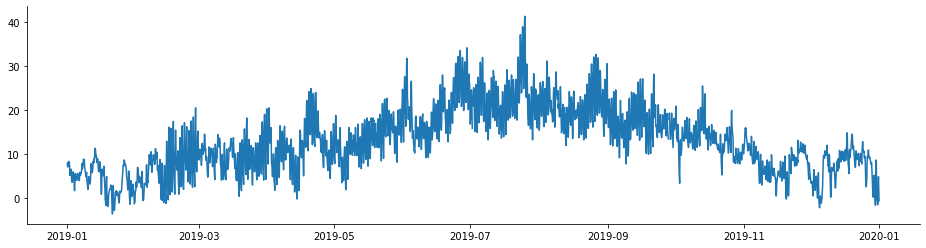

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(orly19.index, orly19);

### Window

The window formalism is the equivalent concept than a groupby with categorical variable.
For each data point, we can create a window of close by points for which we will compute the agregation.
The difference is that here, each point will contribute to many windows instead of a single.

There exist two broad categories of windows.
The expanding window will consider all points from the begining of the serie up to the point of study.
It will always include more and more points into the agregation.
Rolling window will cover a fixed number of points, or a fixed duration.
As a result, points will enter the window but others will be removed from the agregation.

![https://towardsdatascience.com/window-functions-in-pandas-eaece0421f7](../../figures/pandas_window.jpeg)

For this example, we will extract the trend of the data by measuring for each point the average temperature during the previous 24 hours and the previous month.

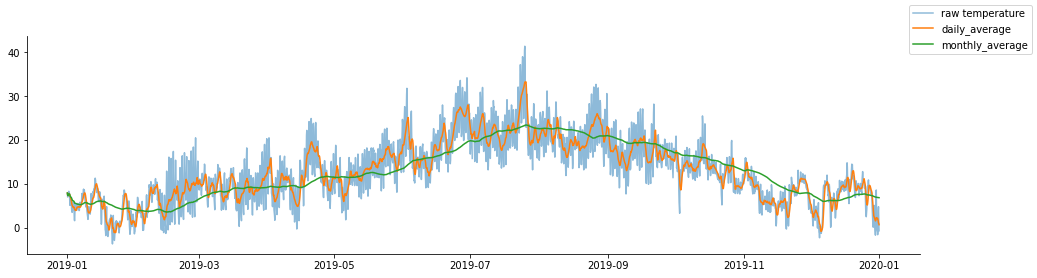

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(orly19.index, orly19, alpha=0.5, label='raw temperature');

daily = orly19.rolling('1d').mean()
ax.plot(daily.index, daily, label='daily_average');

monthly = orly19.rolling('30d').mean()
ax.plot(monthly.index, monthly, label='monthly_average');

fig.legend();

By replacing the time serie with the average temperature during the last 24 hours, we see that we have removed some variations of the data.
The orange curve seems roughly in the middle of the blue band which represent the variations between night and day.
However, we still have large perturbations of this curve because of the variability of the temperature from one day to the next.
With respect to seasonal average, it is expected to have a week of very low or very high temperature.
This is what we observe at the end of april and mid november.
When averaging over a longer period of time this type of variability disapear.
Here, the green curve is much smoother.

#### lag

A limitation of this strategy (and others we will study) is the lag of the metric with respect to the underlying trend.
Imagine that your time serie has a perfect sin shape; meaning that the trend is equal to the serie.
Then the trend is maximal at middle and goes down right after.
However, the window average will have its maximum a bit after the maximum of the real trend.
Indeed, when the average with respect to the maximal point is as follow.

$$S_{T} = \frac{x_T + x_{T-1} ... +x_{T-k+1} + x_{T-k}}{k}$$

And the metric at the next time will be.
$$S_{T+1} = \frac{x_{T+1} + x_{T} ... +x_{T-k+2} + x_{T-k+1}}{k}$$


Then,
$$S_{T+1}-S_{T} = \frac{x_{T+1} - x_{T-k}}{k}$$

which means that even though the underlying trend starts to decrease, the metric keeps increasing as long as the last point have a larger value than the point that do not contribute anymore.
The measured metric is then shifted with respect to the underlying trend.

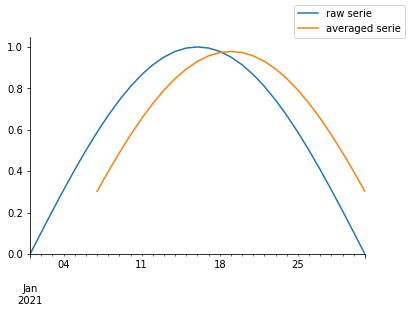

In [ ]:
tmp = pd.Series(np.sin(np.arange(31)/30*np.pi), index= pd.date_range('2021-01-01', '2021-01-31'))
avg = tmp.rolling(7).mean()

fig, ax = plt.subplots()
tmp.plot(ax=ax,label='raw serie');
avg.plot(ax=ax, label='averaged serie');
ax.set_ylim(0, None);
fig.legend();

Finally, it is also possible to observe that the orange curve does not start at the same position than the blue one.
This is because 7 points are required to compute the mean.
As a result, the 6 first points do not have enough data for the computation so it is not performed.
Options exist to compute a partial mean anyway.

### exponential average

The exponential average is another technique to extract the trend from a time serie.
It uses a recurrent formula : it only needs the previous value of the metric to compute the next.
It does not use the past points themselves.
The exponential average is basically the weighted average between the current value of the time serie and the last value of the metric.

$$S_t = \alpha x_t + (1-\alpha) S_{t-1}$$

Where $S_t$ represents the metric at time $t$ and $x_t$ the serie value at this time.
The $\alpha$ parameter represents how much the last time serie value should contribute to the new value of the metric.

With this metric, each time step contributes to future values of the metric, much like an expanded window.
However, their contribution is reduced by a factor $(1-\alpha)$ everytime, which generate a contribution that decreases exponentially, hence the name of the metric.

$$S_t = \alpha x_t + (1-\alpha) S_{t-1} = \alpha x_t + \alpha(1-\alpha) x_{t-1} + \alpha (1-\alpha)^2 S_{t-2}
= \sum \limits_k \alpha (1-\alpha)^{k} x_{t-k}$$

Because the weight of a point decays exponentially as a power of $(1-\alpha)$, the larger the $\alpha$ the faster this point will stop effectively contributing to the metric.
Inversely, the lower the alpha, the more points will be able to contribute.
This can be related to the previous example of fixed time window. 
Exponential average can be considered a fuzzy window average, where the size of the window is defined by $\alpha$.

The concept of exponential averaging appears in many different fields under different formulas.
As a result, there are multiple way to define the effective window size.
The pandas documentation for this technique proposes multiple definitions for the $\alpha$ parameter. 
For the example, we will use the ```halflife``` parameter : $t_{1/2}$.
This parameter is related to $\alpha$ by the following formula.

$$\alpha=1−exp\left(\frac{−ln(2)}{t_{1/2}}\right)$$

This notion of half life is used a lot in radioactivity.
This is the duration after which the weight is divided by two.
After two such periods, the weight is the fourth of its initial value.
Basically, after 4 or 5 such periods the contribution of a point is negligible.
$t_{1/2}$ is then practical to estimate the size of the fuzzy window.


For this example, we will try to compare exponential averaging with fixed time window.
We will compare the daily average with an average with ```halflife='12 hours'```.
This means that after 12 hours, the weight will be ```0.5```.
We then get a window which is rougly one day after twice this period with points that still contribute $25%$ of their value.
Similarly, we will compare the monthly average with an exponential with ```halflife='15 days'```.

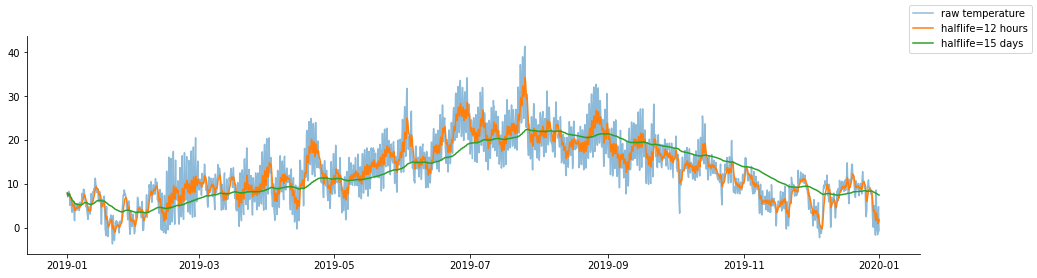

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(orly19.index, orly19, alpha=0.5, label='raw temperature');

daily = orly19.ewm(halflife='12 hours', times=orly19.index).mean()
ax.plot(daily.index, daily, label='halflife=12 hours');

monthly = orly19.ewm(halflife='15 days', times=orly19.index).mean()
ax.plot(monthly.index, monthly, label='halflife=15 days');

fig.legend();

We finally observe similar results than for the fixed window size.
The exponential average has the same trouble of lag of the trend, as we can see with the green curve.
This is basically for the same reason but the mathematical formulation is a bit more complex as it is not a comparison of the incoming point with an exiting piont, but with the relative weight lost by all previous points (or just the metric at the previous point).

The exponential average gives basically the same results than the fixed time window.
It's advantage relies mainly on the fact that it does not require the past points to compute the next value.
Thanks to that, it is much faster to compute, even more in production as one does not need to fetch data from a database.

### double exponential average 

The exponential average, just like fixed time window, suffers from the lag of the metric.
This is problematic from some usages where you want your metric to follow more closely the trend.
Then, double exponential average (or Holt average) was created in order to add a parameter to the parametrisation which could be used to follow more closely the trend.
The parametrisation is as follow.

$$S_{t+1} = l_t + b_t$$

$$l_t = \alpha x_t + (1-\alpha) l_{t-1}$$

$$b_t = \beta (l_t - l_{t-1}) + (1-\beta) b_{t-1}$$

Wit this new parametrisation, we add the $\beta$ parameter which is related to the slope of the serie at time $t-1$.
If we fix $\beta=0$, we find back the simple exponential average.
If $\beta=1$ then we double the amount by which the metrics changes.
If the metric increases because of an increasing serie, then we will increase the metric more in this direction.
If the metric start to decrease, this decrease will be accelerated by $b_t$.

Let's apply this strategy to our simple cosine serie for wich fixed time window used to lag.
Here we have a second parameter to choose : $\beta$.
Here, we will try to fit the best possible $\beta$.
With this strategy we observe that we were able to reduce the lag, at the cost of an excessive value at the center.

/mnt/c/Users/christophe_goudet/Documents/dev/esilv/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


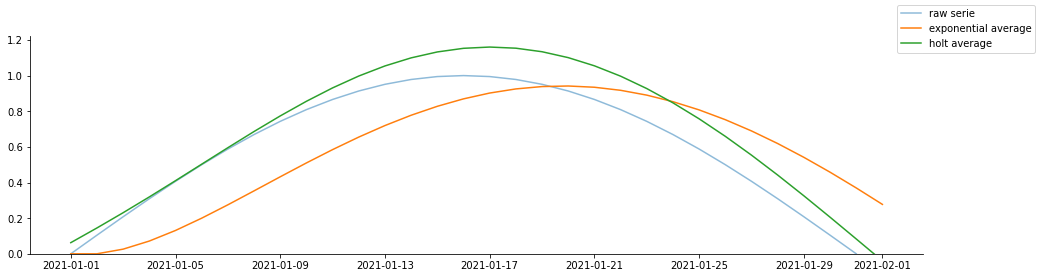

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
tmp = pd.Series(np.sin(np.arange(31)/30*np.pi), index= pd.date_range('2021-01-01', '2021-01-31'))

smoothing_level = 0.25
simplexp = SimpleExpSmoothing(tmp).fit(smoothing_level=smoothing_level,optimized=False)
out = simplexp.predict(0, len(tmp))

holt = Holt(tmp, initialization_method='heuristic').fit(smoothing_level=smoothing_level)
out2 = holt.predict(0, len(tmp))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(tmp.index, tmp,label='raw serie', alpha=0.5);
ax.plot(out.index, out, label='exponential average');
ax.plot(out2.index, out2, label='holt average');
ax.set_ylim(0, None);
fig.legend();

Let's now apply this strategy to the temperature dataset and compare the results with the previous technique.
We observe that the green increases much faster during the first half of the year, peak roughly at the right place and decreases much faster.
While there may be a bit of overshoot at the center, the simple exponential has a much larger excess on the second part of the year.

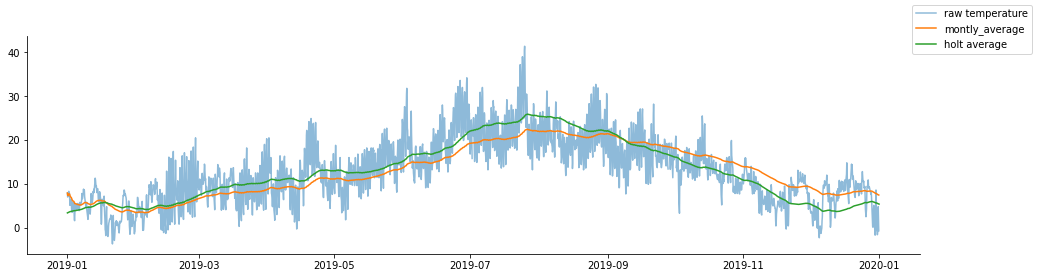

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(orly19.index, orly19, alpha=0.5, label='raw temperature');

monthly = orly19.ewm(halflife='15 days', times=orly19.index).mean()
ax.plot(monthly.index, monthly, label='montly_average');

alpha = 1-np.exp(-np.log(2)/(15*8))
holt = Holt(orly19.fillna(method='ffill'), initialization_method='heuristic').fit(smoothing_level=alpha)
out = holt.predict(0, len(orly19))
ax.plot(out.index, out, label='holt average');

fig.legend();

## Seasonality

A major specificity of time series is the notion of seasonality.
The seasonality of a time serie is the concept that the serie shows a periodic behaviour : it takes roughly the same value after a specific amount of time called the period.
The presence of seasonality brings a lot of insight about the business logic.
It means that some process is repeated again and again.
Understanding this pattern is then a major highlight of an analysis.
For example, an electrocardiogram repeat the same pattern after each heart cycle.
This patterns allows to understand how the two ventricules interact and contract.
The following time serie is purely a seasonal one.

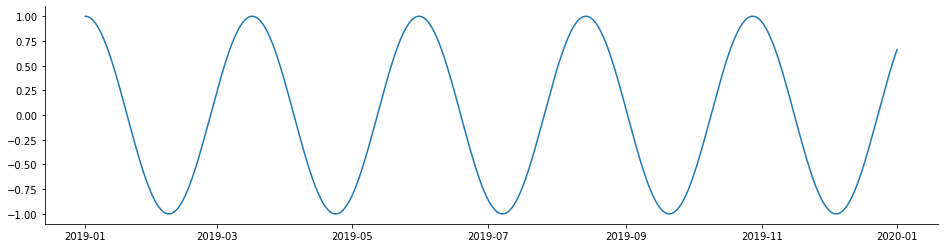

In [ ]:
season = np.cos(np.arange(len(all_ts))*np.pi/300)
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(all_ts, season);

It is however important to note that the repeating pattern may be highly distorded by trend.
In the most simple case, the pattern may just be offset by a trend.
In most complicated cases, its properties in terms of amplitude cas also be dependent on the trend.
In the following figure, the serie is an addition of a simple linearly increasing trend with the previous seasonal one.
Then the initial deifinition of seasonality is wrong because the serie does not take the sames values ever again.
The trend has shifted everything upward.

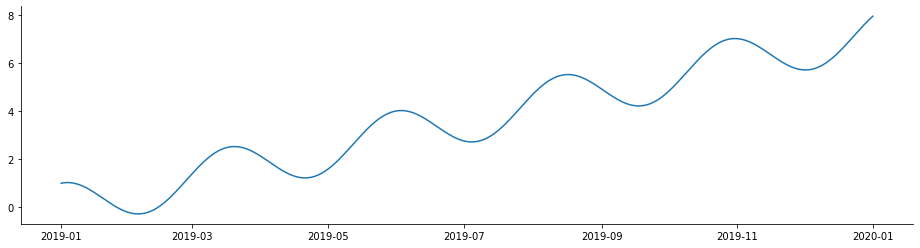

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(all_ts, season+np.arange(len(all_ts))/400);

It is important to note that not all models are additive.
It is also possible to have multiplicative models are more complex situations.
It is up to the analyst to understand which parametrisation better fits the underlying phenomenon.

#### Expert knowledge

Often, the analyst has some kind of expertise on the field and understand the seasonality of the data.
In the case of our temperature, we understand that there is a daily pattern (hot during the day and cold during the night) and also a yearly pattern (hot in summer, cold in winter).
In this situation, simple tools allow to extract the components of a time serie : trend, seasonality and residual.
The following code is a simple method to get the seasonal part of the serie.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(orly19.fillna(method='ffill'), 
                            model='additive', 
                            period=8 #24 hours seasonality
                           )

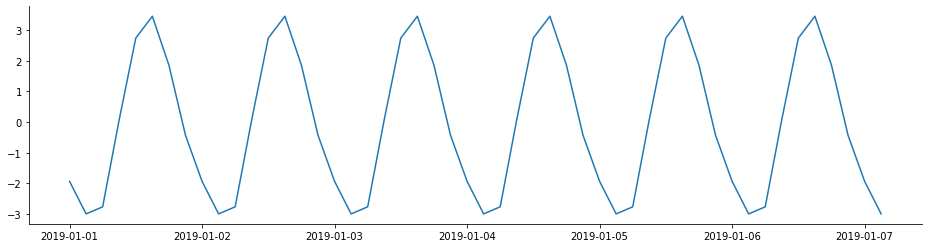

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(result.seasonal.index[:50], result.seasonal[:50]);

With this result, we observe that a new day always start at the bottom of the serie, when the temperature is almost minimal.
We can also observe that in average, the difference of temperature during the day and the night of about 6 degrees.

We can then look at how the trend and seasonal part match the underlying temperature distribution.
We see in the following plot that those two components follow the irregularities of the distribution.
However, we can observe that the parametrisation overestimates the daily fluctuations in january but underestimate them in march.
Our temperature serie then shows a more complex behaviour than trend and seasonality.

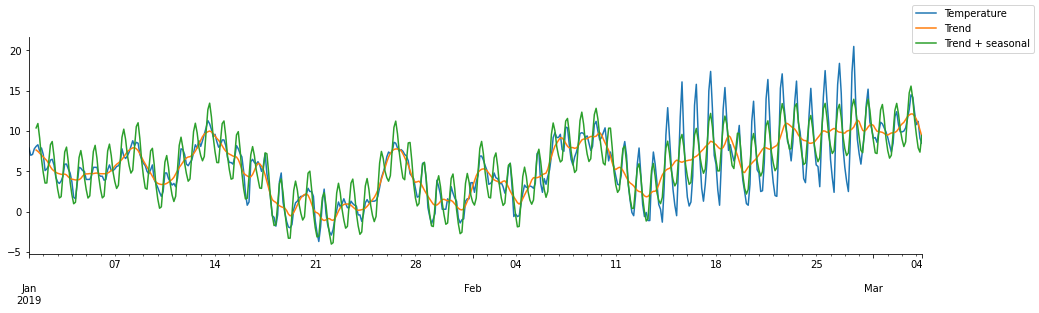

In [ ]:
ind = 500

fig, ax = plt.subplots(figsize=(16, 4))
orly19.iloc[:ind].plot(ax=ax, label='Temperature')
result.trend.iloc[:ind].plot(ax=ax, label='Trend')
(result.trend+result.seasonal).iloc[:ind].plot(ax=ax, label='Trend + seasonal');
fig.legend();

#### Partial autocorrelation

Sometimes the analyst does not have a full knowledge of the seasonality in the time serie, and it can be tricky to see it in a plot.
However, there are ways to numerically estimate if the serie contains periodic phenomenon.
The most simple way is to evaluate the correlation between the serie and the same shifted serie.
In theory, if we shift the serie by 24 hours, we should get roughly the same serie, so the correlation should be high.
Inversely, a shift of only 12 hours should not fit that much.

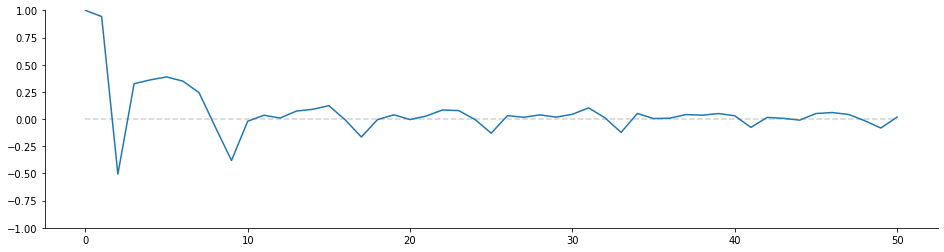

In [ ]:
from statsmodels.tsa.stattools import pacf
out = pacf(orly19.fillna(method='ffill'), nlags=50)
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot([0, 50], [0, 0], '--', color='lightgrey')
ax.plot(out);
ax.set_ylim(-1, 1);

In the graph above, we can observe multiple things.
This graph shows a periodic behaviour, with decreasing intensity.
The periodic shape represents the periodic agreement of the serie with itself during a day.
The maximum of the shape is at the multiples of 8, which corresponds to a day : the serie agrees with itself when two different days are aligned.
Then, the agreement is minimal when midday is aligned with midnight. 

Then we observe that the daily shape becomes smaller and smaller.
This is due to the fact that the serie has trend.
When you perform a lag on the serie, even though the local shape matches, the scales do not.
Then you have a large difference between series values even if they are aligned.
In our situation, detrending the original serie would not improve much the situation because of the season dependence of the amplitude of daily temperature variations.

#### Fourrier

The partial autocorrelation method is limited by the trend of the serie.
Another strategy is to use the Fourrier transform.
This mathematical transformation allows to use the following mathematical property.
Any time serie can be decomposed into a sum of sine and cosine functions with the following formula.


$$y_t = a_0 +  \sum\limits_{p=0}^{n/2-1} \left( a_p cos(2\pi tp/n) + b_p sin(2\pi tp/n) \right) + a_{n/2} cos(\pi t)$$

With this formula, if a specific $p$ is not a natural period of the dataset, its cosine can only be used to fit residual, hence it should not contribute much to the serie.
However, natural periods of the dataset will have larger contribution.
Applying Fourrier transform allows to compute those $a_p$ and to check which ones have a significant contribution.
This strategy even allows to identify multiple natural periods which may not be self evident by the plots.
A more thorough study of time scale analysis is available [there](https://bookdown.org/rdpeng/timeseriesbook/frequency-and-time-scale-analysis.html).

For this example, we will use a larger dataset.
With the temperature from the last 10 years, we expect both daily and yearly periodic effects.
Those two periods should contribute greatly to the decomposition while others should be more marginal.

In [ ]:
orly10 = orly[(orly.index.year>=2010)&(orly.index.year<2020)].copy()
all_ts = pd.date_range('2010-01-01', '2020-01-01', freq='3H', closed='left')

# orly dataset has duplicate timestamp
orly10 = orly10.resample('3H').mean()

# dataset has missing values
orly10 = orly10.reindex(all_ts).fillna(method='ffill')
orly10

2010-01-01 00:00:00    0.800012
2010-01-01 03:00:00    0.600000
2010-01-01 06:00:00    0.100000
2010-01-01 09:00:00    0.100000
2010-01-01 12:00:00    0.700006
                         ...   
2019-12-31 09:00:00   -1.100012
2019-12-31 12:00:00    3.600000
2019-12-31 15:00:00    4.800012
2019-12-31 18:00:00    2.100000
2019-12-31 21:00:00   -0.699988
Freq: 3H, Name: t, Length: 29216, dtype: float64

We can then apply the Fourrier transform to our dataset.
Because all our values are real (Fourrier transform can be applied on complex numbers), we can used an optimised function.
Still, the computed values will be complex (corresponding to the sin and cosine parts), so we take the norm to estimate their contribution.
A good tutorial of the library is available in this [article](https://realpython.com/python-scipy-fft/).

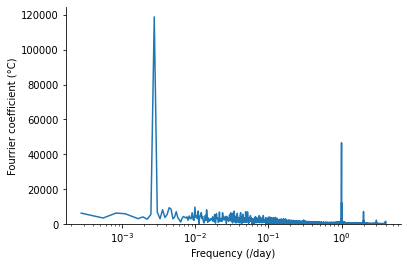

In [ ]:
from scipy.fft import rfft, rfftfreq
fourrier_coefs = rfft(orly10.values)

# Normalisation term
N = len(orly10)

# All possible frequencies in /day
xf = rfftfreq(N,1/8)

fig, ax = plt.subplots()
ax.plot(xf[1:], np.abs(fourrier_coefs)[1:])
ax.set_xscale('log');
ax.set_ylim(0, None)
ax.set_xlabel('Frequency (/day)');
ax.set_ylabel('Fourrier coefficient (°C)');

In [ ]:
xf[np.abs(fourrier_coefs)>20000][1:]

array([0.00273823, 1.        ])

From this result we observe a strong peak around 2.74e-3, a second one around 1, and the rest of the frequencies having much smaller values.
The first peak means that a large cosine contributes to the serie.
This cosine has 2.74e-3 periods during a single day, which means that its period is $1/2.74e-3=365.2$ : one year.
We have found back the repetitive annual pattern of seasons.
Then the second peak correspond to a repetitive daily pattern that we already have studied.
The very first coefficient, that we have not plotted, correspond the the average of the serie which is also quite high.

We also see small peaks at value 2, 3 and 4.
These are called the harmonics of the baseline frequency of 1.
They are frequencies that are multiple of the baseline and often appear in those graphs.

Finally, a lot of very small peaks between the two majors.
Given their low impact, those peaks corresponds to cosine which define the various statistical fluctuations of the time series.
As a result, those cosine components are meaningless so we can remove them.
Another nice property of the Fourrier transform is that you can get back the initial serie from the coefficient using the inverse transformation.
You can also modify the coefficient (for example zeroing the meaningless ones) and compute a cleaner serie without those.

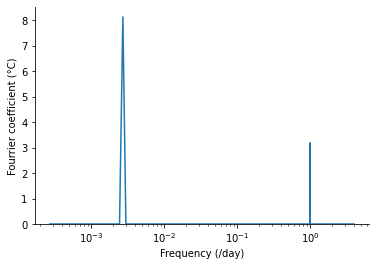

In [ ]:
fourrier_coefs[np.abs(fourrier_coefs)<20000] = 0

fig, ax = plt.subplots()
ax.plot(xf[1:], 2/N*np.abs(fourrier_coefs)[1:])
ax.set_xscale('log');
ax.set_ylim(0, None)
ax.set_xlabel('Frequency (/day)');
ax.set_ylabel('Fourrier coefficient (°C)');

In [ ]:
from scipy.fft import irfft
cleaned_serie = pd.Series(irfft(fourrier_coefs), index=all_ts)

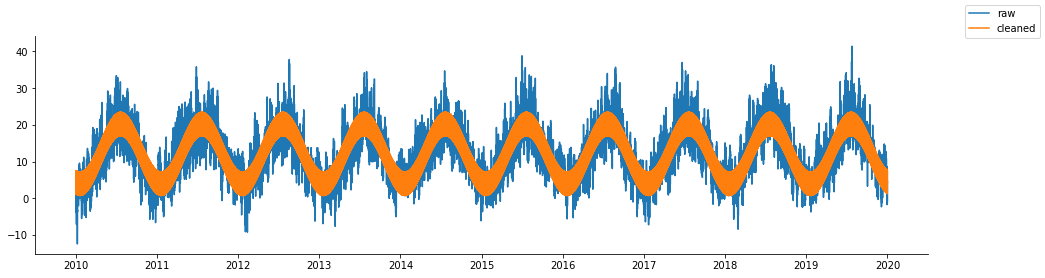

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(orly10.index, orly10, label='raw')
ax.plot(all_ts, cleaned_serie, label='cleaned');
fig.legend();

From this result we see that we created a cleaned time serie which follows very well the annual variations.
We also see that the cleaned seris is quite thick because it includes much fasters variations.
Lets look at a zoom.

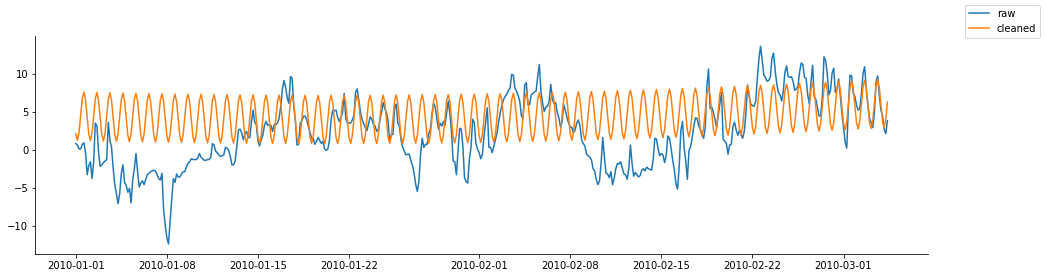

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
ind = 500
ax.plot(orly10.index[:ind], orly10[:ind], label='raw')
ax.plot(all_ts[:ind], cleaned_serie[:ind], label='cleaned');
fig.legend();

With this second graph we see that the cleaned time serie is extremely regular.
It does not fit all the weekly fluctuations of the data.
However, we can observe that the intra day fluctuations are pefectly aligned. 
With the Fourrier transform, we were able to extract multiple periodic patterns at very different scales.

### Feature engineering

Time series are by themselves a succession of values.
But is is also possible to create additional features at each time.
Those features can then be used as tabular ones to do similar analysis than what has been done before.
The point here is not the value of the serie but at which period this value appear.

#### date part
To create time features, the analyst can identify the properties of each timestamp of the serie.
Which day of the week the timestamp corresponds to.
This could help separate effects on weekends from business day.
Is the day a public holiday?
Which month is it? 
In our example, we expect the temperatures to be higher is summer.
Is it the start or the beginning of a month?
In sales time series, we could expect higher sales after payday.
There is a lot of such features that can be created.
The analyst can then apply agregation on them to identify patterns.
The following function, taken from the ```fastai``` library generates multiple features for each timestamp.

In [ ]:
from src.data.common import add_datepart
df = add_datepart(orly19.reset_index(), 'index', drop=False)
df.head()

index         t  indexYear  indexMonth  indexWeek  indexDay  \
0 2019-01-01 00:00:00  7.899988       2019           1          1         1   
1 2019-01-01 03:00:00  6.999994       2019           1          1         1   
2 2019-01-01 06:00:00  7.100000       2019           1          1         1   
3 2019-01-01 09:00:00  7.800012       2019           1          1         1   
4 2019-01-01 12:00:00  8.100000       2019           1          1         1   

   indexDayofweek  indexDayofyear  indexIs_month_end  indexIs_month_start  \
0               1               1              False                 True   
1               1               1              False                 True   
2               1               1              False                 True   
3               1               1              False                 True   
4               1               1              False                 True   

   indexIs_quarter_end  indexIs_quarter_start  indexIs_year_end  \
0                False                   True             False   
1                False                   True             False   
2                False                   True             False   
3                False                   True             False   
4                False                   True             False   

   indexIs_year_start  indexElapsed  
0                True  1.546301e+09  
1                True  1.546312e+09  
2                True  1.546322e+09  
3                True  1.546333e+09  
4                True  1.546344e+09

#### radial function

The previous strategy creates categorical features from a date.
Instead, on could create a continuous value that represent the agreement of the date with some asumption.

For example, we could wish for a variable telling us how close we are from the usual warmer part of the day (2pm).
We can use radial functions to do that.
Those periodic functions peak at a predefine phase (a chosen hour of the day) and goes to 0 furhter from this phase.
The analyst can also choose the width of the peak.
Radial functions have the following formula for a single period.

$$\phi(x) = exp(-\frac{(x-m)^2}{2\alpha^2} )$$

This function will be close to one the closest a measurement is from $m$ (2pm in our example).
The weight for further points will decrease exponentially, depending on the width of the gaussian.
We observe in the following example that indeed our new feature is well synchronised with daily variations.
The power of this strategy is further detailed in this [pyData conference](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjbrsn5zJLvAhWMlhQKHf2zApsQtwIwAHoECAMQAw&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3D68ABAU_V8qI&usg=AOvVaw3WDzLbc_f6NXLBhEWBfxrq).

In [ ]:
alpha = 3 #hours
center_hour = 14
df['max_day'] = np.exp(-1/2 / alpha**2 * (df['index'].dt.hour - center_hour)**2)
df['max_day_thin'] = np.exp(-1/2 / (alpha/5)**2  * (df['index'].dt.hour - center_hour)**2)

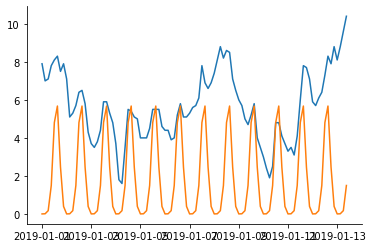

In [ ]:
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['t'])
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['max_day']*6);

#### Mean shift
We can also create numerical features by comparing the timestamp or the time serie value with respect to a baseline.
For example, we could compare the value of the time serie with respect to its trend. 
Is the temperature higher than what we might expect this season and by how much?
This can be also applied with respect to the seasonality.

In [ ]:
df['model'] = cleaned_serie[-len(df):].values
df['diff_model'] = df['t'] - df['model']

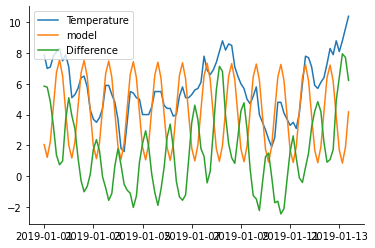

In [ ]:
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['t'], label='Temperature');
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['model'], label='model');
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['diff_model'], label='Difference');
plt.legend();

#### Cosine features 

Finally, we can create features related to periodicity.
If the number of the day within the year is extracted there will be a break at the new year where the day 365 will be numerically very far from the day 1 even though they are actually close together.
With periodic data, we could extract the corresponding phase of the periodicity at which the event appear.
The phase has a similar problem. 
If it is defined in the interval $(-\pi, \pi)$, then points at $-\pi$ and $\pi$ will be very far even though they are basically at the same phase.

If we take for instance the phase of the day : ```hour/24```, we would get this cut at midnight.
If instead we take the sine of this phase (times $2\pi$), 11pm and 1am would be actually quite close as $sin(0.95*2*\pi)\simeq sin(0.05*2\pi) \simeq 0$.
But this raises another problem : midday would also have the same value as $sin(2\pi*0.5)=0$.
If this is not intended, we need another way to separate midnight and midday.
We can add the cosine for this.
Indeed, if two points are wrongly close to each other using the sine, they will be far appart using the cos.
Combining those two features allows to have a decent notion of distance between timestamps.

In [ ]:
df['indexcos'] = np.cos(2*np.pi *df['index'].dt.hour / 24)
df['indexsin'] = np.sin(2*np.pi *df['index'].dt.hour / 24)

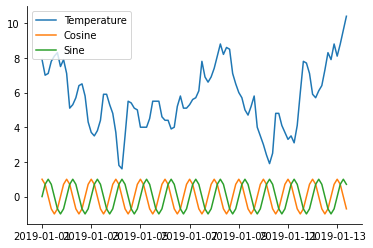

In [ ]:
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['t'], label='Temperature');
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['indexcos'], label='Cosine');
plt.plot(df.iloc[:100]['index'], df.iloc[:100]['indexsin'], label='Sine');
plt.legend();

## Conclusion

Times series represent the variations of one or several metric over time.
They are extremely present in many dataset, even though not always treated as such, because we often want to understand a concept to predict the future.
We have presented in this course multiple ways to characterise a serie.
First we have seen multiple methods to estimate the trend of a serie.
Then methods to discuss the various periodicities of the serie have be presented.
Finally, time series are often treated in predictive projects.
Even though time serie prediction is out of the scope of this course, several techniques to create features out of timestamps have been discussed, to later integrate into machine learning algorithms.